# Quantum Imaginary Time Evolution ab initio

In [1]:
import numpy as np
np.warnings.filterwarnings('ignore')

import pickle

from scipy.linalg import expm
from scipy.linalg import lstsq
from scipy.linalg import eigh

from pprint import pprint
from tqdm import tqdm

# Everything we need from Qiskit
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import execute, Aer
from qiskit.quantum_info import Pauli

from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.aqua.components.initial_states import Custom

import qutip as qt

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(16,8)})
sns.set()

import itertools

import sys
sys.path.append("../src/")
from hamiltonian import *
from utils import *
from qiskit_circuits import *
from qite import *

## Testing operator construction

In [2]:
H=hamiltonian_matrix(Nmax=4,J=1,interaction="Daejeon")
H_qubit = GrayCodeHamiltonian(H)
eig_exact,_=eigh(H)
eig_q,_=eigh(H_qubit.matrix)
print(f"N qubits: {H_qubit.N_qubits}")
print(eig_exact[0])
print(eig_q[0])

H = hamiltonian_matrix(Nmax=4,J=1,interaction="toy") 
H_qubit = GrayCodeHamiltonian(H)
eig_q2,_=eigh(H_qubit.matrix)
print(eig_q2[0])



N qubits: 3
-1.8460233327408204
-1.8460233327408346
-2.0456708984064313


In [3]:
## Get list of sigmas (all pauli terms with odd number Y gates)
n_qubits=H_qubit.N_qubits
## vector of WeightedPauliOperators representing vector Sigma
sigmas=sigma_terms(n_qubits)

## Construct b
b_pauli_terms=b_terms(H_qubit,sigmas)
# for bI in b_pauli_terms:
#     print(bI)
      
## Construct S
S_pauli_terms=S_terms(sigmas)

pauli_set=get_intersection_pauli_terms(H_qubit,b_pauli_terms,S_pauli_terms)

commuting_sets=get_commuting_sets(sorted(pauli_set))
for p in commuting_sets:
    print(p, commuting_sets[p],p[::-1])




XX ['II', 'IX', 'XI', 'XX'] XX
XY ['IY', 'XY'] YX
XZ ['IZ', 'XZ'] ZX
YX ['YI', 'YX'] XY
YY ['YY'] YY
YZ ['YZ'] ZY
ZX ['ZI', 'ZX'] XZ
ZY ['ZY'] YZ
ZZ ['ZZ'] ZZ


## Prepare and run the evolution circuit for Gray code encoding  

Testing threshold used when solving for A

In [2]:
time_steps=5
# time_steps=20
delta_time=0.01
verbose=False
backend = 'statevector_simulator'
initialization="zeros"

Energy_table=[]
H=hamiltonian_matrix(Nmax=4,J=1,interaction="Daejeon")
H_qubit = GrayCodeHamiltonian(H)

backend = 'statevector_simulator'
sv_energies_50=qite_experiment(H_qubit,time_steps,delta_time,backend,initialization,A_threshold=1e-10)

for threshold in [1e-1,1e-2,1e-5,1e-10]:
    backend = 'qasm_simulator'
    Energies=qite_experiment(H_qubit,time_steps,delta_time,backend,initialization,A_threshold=threshold)
    Energy_table.append(Energies)

100%|██████████| 5/5 [00:15<00:00,  3.14s/it]


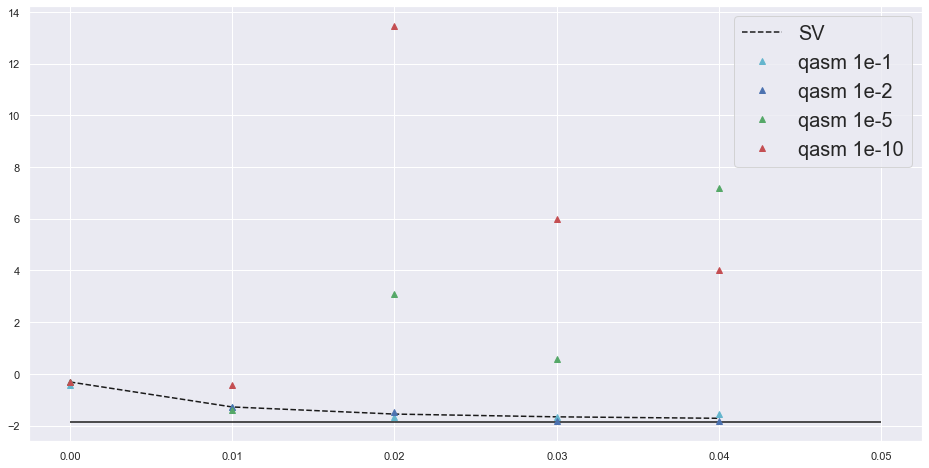

In [3]:
eig_exact=eigh(H)[0][0]
time=[delta_time*t for t in range(time_steps)]
plt.hlines(eig_exact,0,delta_time*time_steps,"k")
plt.plot(time,sv_energies_50,'k--',label="SV")
plt.plot(time,Energy_table[0],'c^',label="qasm 1e-1")
plt.plot(time,Energy_table[1],'b^',label="qasm 1e-2")
plt.plot(time,Energy_table[2],'g^',label="qasm 1e-5")
plt.plot(time,Energy_table[3],'r^',label="qasm 1e-10")
plt.legend(prop={'size': 20})

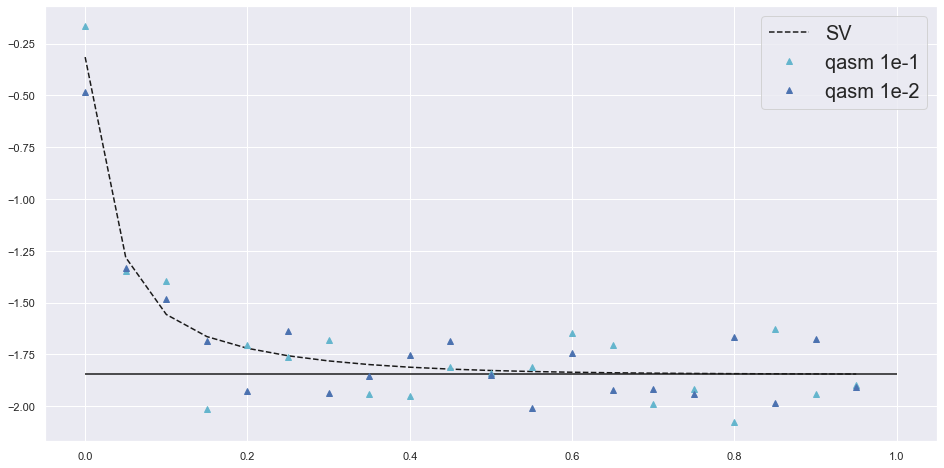

In [26]:
eig_exact=eigh(H)[0][0]
time=[delta_time*t for t in range(time_steps)]
plt.hlines(eig_exact,0,delta_time*time_steps,"k")
plt.plot(time,sv_energies_50,'k--',label="SV")
plt.plot(time,Energy_table[0],'c^',label="qasm 1e-1")
plt.plot(time,Energy_table[1],'b^',label="qasm 1e-2")
# plt.plot(time,Energy_table[2],'g^',label="qasm 1e-5")
# plt.plot(time,Energy_table[3],'r^',label="qasm 1e-10")
plt.legend(prop={'size': 20})

Testing different time steps.  Approximation of normalization coefficient requires $\Delta t\ge0.1$ 

In [3]:
time_steps=20
verbose=False
initialization="zeros"

Energy_table_time_sv=[]
Energy_table_time_qasm=[]

H=hamiltonian_matrix(Nmax=4,J=1,interaction="Daejeon")
H_qubit = GrayCodeHamiltonian(H)

for delta_time in [0.001,0.01]:
    backend = 'qasm_simulator'
    Energies=qite_experiment(H_qubit,time_steps,delta_time,backend,initialization,A_threshold=1e-2)
    Energy_table_time_qasm.append(Energies)

    backend = 'statevector_simulator'
    Energies=qite_experiment(H_qubit,time_steps,delta_time,backend,initialization,A_threshold=1e-2)
    Energy_table_time_sv.append(Energies)

    

100%|██████████| 20/20 [00:11<00:00,  1.68it/s]


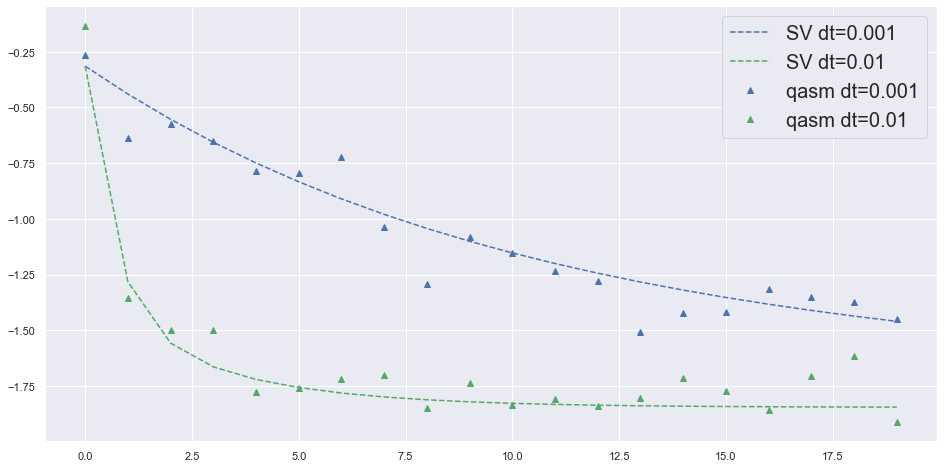

In [4]:
# time_steps=100
# delta_time=0.01
time=[t for t in range(time_steps)]
plt.plot(time,Energy_table_time_sv[0],'b--',label="SV dt=0.001")
plt.plot(time,Energy_table_time_sv[1],'g--',label="SV dt=0.01")
# plt.plot(time,Energy_table_time_sv[2],'r--',label="SV dt=0.05")

plt.plot(time,Energy_table_time_qasm[0],'b^',label="qasm dt=0.001")
plt.plot(time,Energy_table_time_qasm[1],'g^',label="qasm dt=0.01")
# plt.plot(time,Energy_table_time_qasm[2],'r^',label="qasm dt=0.05")
plt.legend(prop={'size': 20})

Testing merge $\{A+i\}$ into single operators after different number of iterations.

In [28]:
time_steps=50
delta_time=0.01
verbose=False
backend = 'statevector_simulator'
initialization="zeros"

Energy_table_step=[]
H=hamiltonian_matrix(Nmax=4,J=1,interaction="Daejeon")
H_qubit = GrayCodeHamiltonian(H)

merge_iterations=[0,1,2,10,25]
for cs in merge_iterations:
    if cs==0:
        cs=None
    Energies=qite_experiment(H_qubit,time_steps,delta_time,backend,initialization,A_threshold=1e-2,cstep=cs)
    Energy_table_step.append(Energies)

100%|██████████| 50/50 [00:30<00:00,  1.64it/s]


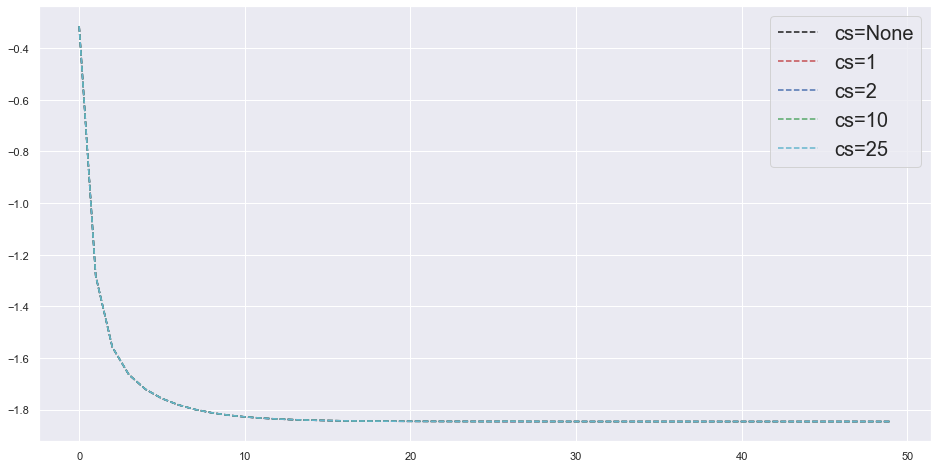

In [30]:
time=[t for t in range(time_steps)]
plt.plot(time,Energy_table_step[0],'k--',label="cs=None")
plt.plot(time,Energy_table_step[1],'r--',label="cs=1")
plt.plot(time,Energy_table_step[2],'b--',label="cs=2")
plt.plot(time,Energy_table_step[4],'g--',label="cs=10")
plt.plot(time,Energy_table_step[4],'c--',label="cs=25")
plt.plot()
plt.legend(prop={'size': 20})


In [37]:
## Combining A 
time_steps=50
delta_time=0.01
verbose=False
backend = 'qasm_simulator'
initialization="zeros"

Energy_table_step_qasm=[]
H=hamiltonian_matrix(Nmax=4,J=1,interaction="Daejeon")
H_qubit = GrayCodeHamiltonian(H)
Energies_SSM=qite_experiment(H_qubit,time_steps,delta_time,backend,initialization,A_threshold=1e-2,cstep=1)

100%|██████████| 50/50 [01:28<00:00,  1.78s/it]


3


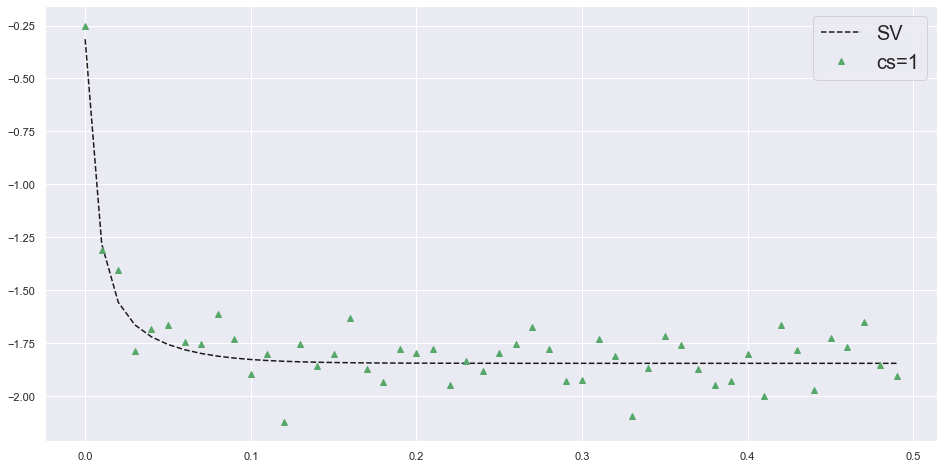

In [39]:
print(H_qubit.N_qubits)
time=[0.01*t for t in range(time_steps)]
plt.plot(time,Energy_table_step[0],'k--',label="SV")
plt.plot(time,Energies_SSM,'g^',label="cs=1")
plt.plot()
plt.legend(prop={'size': 20})

## N=8

In [22]:
time_steps=100
delta_time=0.01
verbose=False
backend = 'statevector_simulator'
initialization="zeros"

H=hamiltonian_matrix(Nmax=4,J=1,interaction="toy")
H_qubit = GrayCodeHamiltonian(H)
n_qubits=H_qubit.N_qubits
print(n_qubits)

# sv_energies,_=qite_experiment(H_qubit,time_steps,delta_time,backend,initialization,A_threshold=1e-10)
# print(sv_energies)


3


In [52]:
time_steps=100
delta_time=0.01
verbose=False
backend = 'statevector_simulator'
initialization="zeros"
H=hamiltonian_matrix(Nmax=14,J=1,interaction="toy")
H_qubit = GrayCodeHamiltonian(H)
n_qubits=H_qubit.N_qubits


Energy_table_step_3q=[]
merge_iterations=[None,1,2,10,25]
for cs in merge_iterations:
    Energy_table_step_3q.append(qite_experiment(H_qubit,time_steps,delta_time,backend,initialization,cstep=cs))

100%|██████████| 100/100 [02:08<00:00,  1.29s/it]


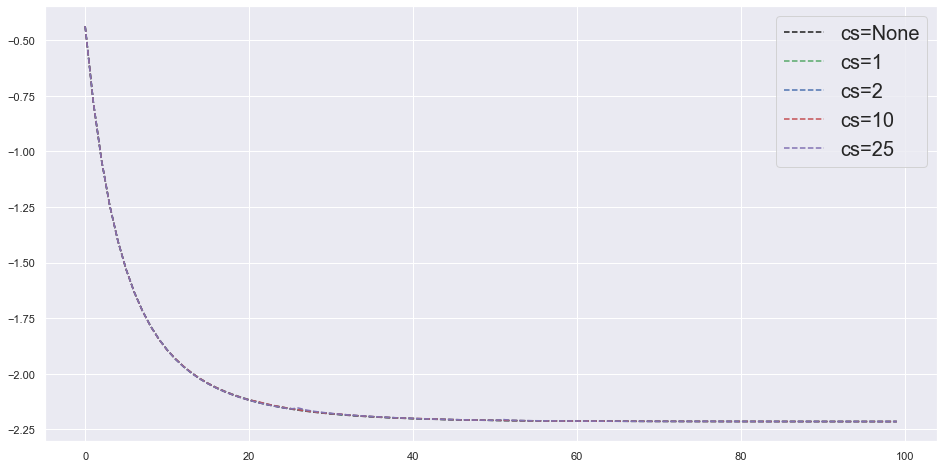

In [53]:
time=[t for t in range(time_steps)]
plt.plot(time,Energy_table_step_3q[0],'k--',label="cs=None")
plt.plot(time,Energy_table_step_3q[1],'g--',label="cs=1")
plt.plot(time,Energy_table_step_3q[2],'b--',label="cs=2")
plt.plot(time,Energy_table_step_3q[3],'r--',label="cs=10")
plt.plot(time,Energy_table_step_3q[4],'m--',label="cs=25")
plt.legend(prop={'size': 20})

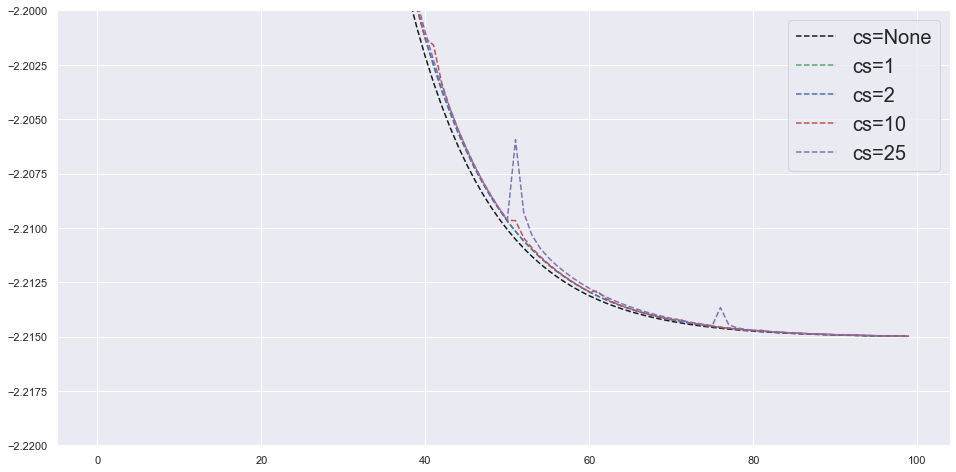

In [58]:
time=[t for t in range(time_steps)]
plt.plot(time,Energy_table_step_3q[0],'k--',label="cs=None")
plt.plot(time,Energy_table_step_3q[1],'g--',label="cs=1")
plt.plot(time,Energy_table_step_3q[2],'b--',label="cs=2")
plt.plot(time,Energy_table_step_3q[3],'r--',label="cs=10")
plt.plot(time,Energy_table_step_3q[4],'m--',label="cs=25")
plt.ylim(-2.22,-2.20)
plt.legend(prop={'size': 20})

In [6]:
time_steps=100
delta_time=0.01
verbose=False
backend = 'qasm_simulator'
initialization="zeros"

qasm_energies_table_cs=[]

H=hamiltonian_matrix(Nmax=14,J=1,interaction="toy")
H_qubit = GrayCodeHamiltonian(H)
n_qubits=H_qubit.N_qubits

Energy_table_step_qasm_3q=[]
merge_iterations=[1,2,10]
for cs in merge_iterations:
    Energy_table_step_qasm_3q.append(qite_experiment(H_qubit,time_steps,delta_time,backend,initialization,A_threshold=1e-2,cstep=cs))

100%|██████████| 100/100 [15:47<00:00,  9.48s/it]


In [ ]:
time=[t for t in range(time_steps)]
plt.plot(time,Energy_table_step_3q[0],'k--',label="SV")
plt.plot(time,Energy_table_step_qasm_3q[0],'c^',label="cs=None")
plt.plot(time,Energy_table_step_qasm_3q[1],'g^',label="cs=1")
plt.plot(time,Energy_table_step_qasm_3q[2],'b^',label="cs=2")
plt.plot(time,Energy_table_step_qasm_3q[3],'b^',label="cs=10")
# plt.xlim(60,100)
# plt.ylim(-2.2151,-2.2145)
plt.legend(prop={'size': 20})

## Jordan Wigner

In [59]:
time_steps=10
delta_time=0.01
verbose=False
backend = 'statevector_simulator'
initialization="zeros"

qasm_energies_table_cs=[]

H=hamiltonian_matrix(Nmax=4,J=1,interaction="toy")
H_qubit = JordanWignerHamiltonian(H)
n_qubits=H_qubit.N_qubits

Energy_table_step_3q_jw=[]
merge_iterations=[None,1,2]
for cs in merge_iterations:
    Energy_table_step_3q_jw.append(qite_experiment(H_qubit,time_steps,delta_time,backend,initialization,A_threshold=1e-2,cstep=cs))

100%|██████████| 10/10 [00:00<00:00, 72.40it/s]


In [ ]:
time_steps=10
delta_time=0.01
verbose=False
backend = 'statevector_simulator'
initialization="zeros"

qasm_energies_table_cs=[]

H=hamiltonian_matrix(Nmax=4,J=1,interaction="toy")
H_qubit = JordanWignerHamiltonian(H)
n_qubits=H_qubit.N_qubits

Energy_table_step_3q_jw=[]
merge_iterations=[None,1,2]
for cs in merge_iterations:
    Energy_table_step_3q_jw.append(qite_experiment(H_qubit,time_steps,delta_time,backend,initialization,A_threshold=1e-2,cstep=cs))